In [51]:
import pyvisa
import datetime
import json
import time
import numpy as np
import matplotlib.pyplot as plt

In [52]:
data_dir = 'C://Users//kashkin//Desktop//keithley data//'
current_limit = 1.0e-6
soak_time = 5

In [63]:
experiment_name = 'initial testing'
data_points = 11
input_voltages = list(np.linspace(0, -10, num=data_points))
measured_voltages = []
measured_currents = []

In [54]:
### Connect to keithley
rm = pyvisa.ResourceManager()
print(rm.list_resources())
keithley = rm.open_resource('GPIB1::11::INSTR')
print("Using " + keithley.query('*IDN?'))

('TCPIP0::18.25.28.214::inst0::INSTR', 'TCPIP0::18.25.28.21::inst0::INSTR', 'TCPIP0::18.25.25.62::inst0::INSTR', 'ASRL1::INSTR', 'GPIB1::11::INSTR')
Using Keithley Instruments Inc., Model 2657A, 4033749, 1.1.8



In [56]:
# Configure as voltage source
keithley.write(' \
    smua.source.func = smua.OUTPUT_DCVOLTS \n\
    display.smua.measure.func = display.MEASURE_DCAMPS \n\
    smua.measure.autozero = smua.AUTOZERO_ONCE \n\
    smua.measure.autorangei = smua.AUTORANGE_ON \n\
    smua.source.limiti = {i_lim} \
    '.format(i_lim = current_limit))

235

In [57]:
# Apparently an interlock check, not sure if it's useful
keithley.write("counter = errorqueue.count")
error_count = keithley.query("print(counter)")[:-1]
if float(error_count) > 0:
    keithley.write("errorId = errorqueue.next()")
    error_id = keithley.query("print(errorId)")[:-1]
    if float(error_id) == 8.02:
        raise AssertionError()
    print("Error occured: " + str(error_id))

Error occured: -2.85000e+02


In [64]:
# Iterate through data points
for voltage in input_voltages:
    keithley.write('smua.source.levelv = %s'%voltage)
    keithley.write("ireading, vreading = smua.measure.iv(smua.nvbuffer1, smua.nvbuffer2)")
    measured_current = keithley.query("print(ireading)")[:-1] # to remove \n string at end
    measured_voltage = keithley.query("print(vreading)")[:-1]

    measured_currents.append(measured_current)
    measured_voltages.append(measured_voltage)

In [65]:
print(measured_voltages, measured_currents)

['-2.36019e-03', '-1.00428e+00', '-2.00393e+00', '-3.00435e+00', '-4.00404e+00', '-5.00370e+00', '-6.00232e+00', '-7.00275e+00', '-8.00281e+00', '-9.00318e+00', '-1.00032e+01'] ['9.47363e-13', '-1.79239e-11', '-1.83886e-11', '-1.87263e-11', '-1.89177e-11', '-1.90398e-11', '-1.91692e-11', '-1.93212e-11', '-1.95273e-11', '-1.96608e-11', '-1.98718e-11']


In [66]:
aggregate_data = {'input_voltages':input_voltages,'measured_voltages':measured_voltages,'measured_currents':measured_currents}

filename = data_dir + experiment_name + '_ %s'%datetime.datetime.now().strftime('%Y_%m_%d-%H_%M_%S') + '.json'

with open(filename, 'w') as file:
    json.dump(aggregate_data, file)

print('saved to %s' %{filename})

saved to {'C://Users//kashkin//Desktop//keithley data//initial testing_ 2022_07_07-19_43_53.json'}


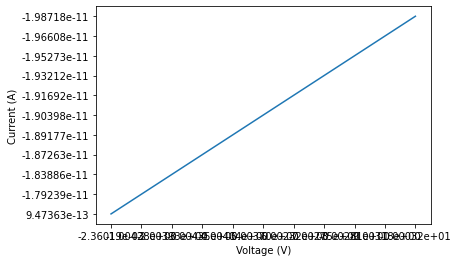

In [67]:
plt.plot(measured_voltages, measured_currents)
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.show()

In [68]:
#Turn off output and drain capacitors
print("\nSetting source voltage to 0 V")
keithley.write("smua.source.levelv = 0")

print("Wait {}s until capacitors are fully discharged".format(soak_time))
time.sleep(soak_time)

print("Turning off output")
keithley.write("smua.source.output = 0")

print("Closing Keithley connection")
keithley.close()


Setting source voltage to 0 V
Wait 5s until capacitors are fully discharged
Turning off output
Closing Keithley connection
